In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense


In [3]:
meta_df = pd.read_csv('symbols_valid_meta.csv')
print("Total Tickers:", len(meta_df))

# Show first few rows to confirm csv loads
meta_df.head()


Total Tickers: 8049


,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAAU,Perth Mint Physical Gold ETF,P,,Y,100.0,N,NaN,AAAU,AAAU,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
4,Y,AADR,AdvisorShares Dorsey Wright ADR ETF,P,,Y,100.0,N,NaN,AADR,AADR,N


In [4]:
# Filter Stocks
filtered = meta_df[(meta_df['ETF'] == 'N') & (meta_df['Symbol'].notnull())]
tickers = filtered['Symbol'].unique()[:1]  # You can change the number here
print("Selected ticker:", tickers[0])
ticker = tickers[0]

# Download Stock Price Data
df = yf.download(ticker, start='2020-01-01', end='2024-12-31')
df = df[['Close']]
print("Downloaded data shape:", df.shape)
print(df.head())


Selected ticker: A
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Downloaded data shape: (1257, 1)
Price           Close
Ticker              A
Date                 
2020-01-02  82.885246
2020-01-03  81.554489
2020-01-06  81.795540
2020-01-07  82.046280
2020-01-08  82.856316


In [5]:
ticker = 'AAPL'
df = yf.download(ticker, start='2020-01-01', end='2024-12-31')[['Close']]
print("Data shape:", df.shape)


[*********************100%***********************]  1 of 1 completed

Data shape: (1257, 1)


In [6]:
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

N = 5  # Number of lags
X, y = [], []
for i in range(N, len(df)):
    X.append(df['Close'].values[i-N:i])
    y.append(df['Close'].values[i])

X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))  # RNN input shape


In [7]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [8]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential([
    Input(shape=(N, 1)),
    SimpleRNN(50, activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


In [9]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0403 - val_loss: 0.0018
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3413e-04 - val_loss: 8.5828e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 4.1044e-04 - val_loss: 9.7814e-04
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 4.6808e-04 - val_loss: 4.9597e-04
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 3.6133e-04 - val_loss: 4.9527e-04
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 3.7697e-04 - val_loss: 4.0435e-04
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 3.6390e-04 - val_loss: 4.5228e-04
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 3.3911e-04 - val_loss: 3.5575e-04
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 2.8205e-04 - val_loss: 7.4007e-04
Epoch 10/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 3.3504e-04 - val_loss: 2.8015e-04
Epoch 11/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 2.9107e-04

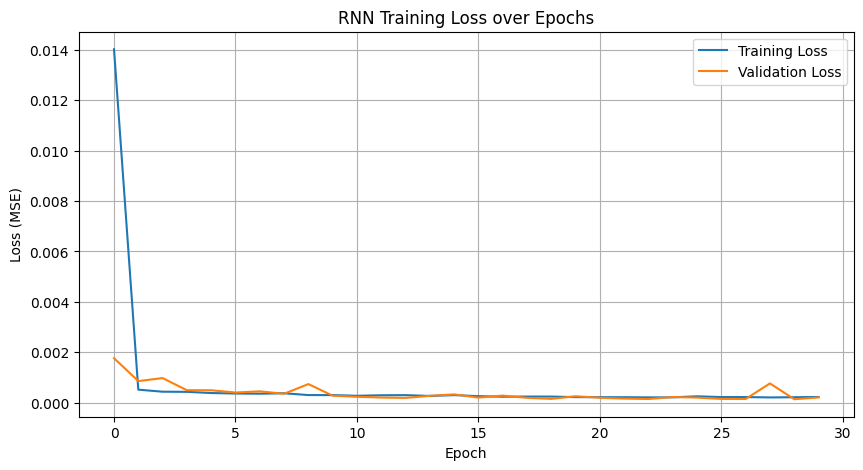

In [10]:
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

print("MSE:", mean_squared_error(y_test_inv, y_pred_inv))
print("R^2 Score:", r2_score(y_test_inv, y_pred_inv))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MSE: 28.499717926333805
R^2 Score: 0.9563039434125808


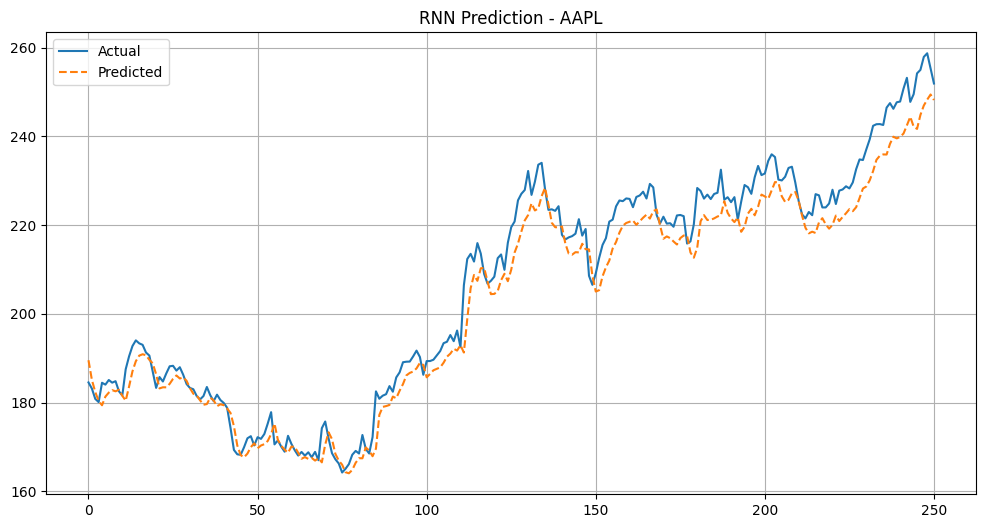

In [12]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted', linestyle='--')
plt.title(f'RNN Prediction - {ticker}')
plt.legend()
plt.grid(True)
plt.show()
